### Group Project 5: Choose-your-own-adventure Hackathon

We've chosen the Intel Image Classification Kaggle challenge for our hackathon. More details can be found [here](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), but essentially, it's a challenge to classify 150x150 color images of natural features among 6 target classes. We will try a variety of approaches to see how high we can get our classification accuracy.

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # need for file enumeration
import pickle

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

# some more image preprocessing
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip
from tensorflow.keras.layers import RandomHeight, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomWidth, RandomZoom

# pre-trained
from tensorflow.keras.applications import VGG19

# metrics
from sklearn.metrics import ConfusionMatrixDisplay

# For reproducibility
np.random.seed(42)

---
##### Data Acquisition

In [2]:
# load train images
train_path = './data/seg_train/seg_train'
train_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = train_datagen.flow_from_directory(
    train_path,
    target_size = (150, 150),
    batch_size = 15_000,
    class_mode = 'categorical')

X_train, y_train = itr.next()

Found 14034 images belonging to 6 classes.


In [3]:
# load validation images
val_path = './data/seg_test/seg_test'
val_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = val_datagen.flow_from_directory(
    val_path,
    target_size = (150, 150),
    batch_size = 3_000,
    class_mode = 'categorical')

X_val, y_val = itr.next()

Found 3000 images belonging to 6 classes.


In [4]:
# load test images
test_path = './data/seg_pred'
test_datagen = ImageDataGenerator(rescale = 1. / 255)
itr = test_datagen.flow_from_directory(
    test_path,
    target_size = (150, 150),
    batch_size = 7_500,
    class_mode = None)

X_test = itr.next()

Found 7301 images belonging to 1 classes.


In [5]:
class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

---
##### Exploratory Data Analysis

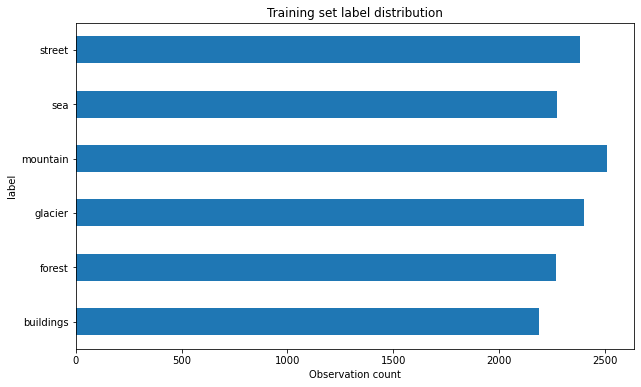

In [6]:
# how's our distribution of labels in the training set?
plt.figure(figsize = (10, 6))
plt.title('Training set label distribution')
plt.xlabel('Observation count')
train_class_labels = pd.DataFrame([class_labels[np.argmax(x)] for x in y_train], columns = ['label'])
train_class_groups = train_class_labels.groupby('label')['label'].count()
train_class_groups.plot.barh();

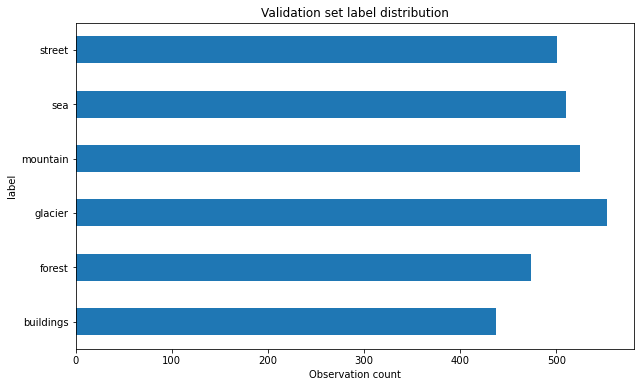

In [7]:
# how's our distribution of labels in the validation set?
plt.figure(figsize = (10, 6))
plt.title('Validation set label distribution')
plt.xlabel('Observation count')
val_class_labels = pd.DataFrame([class_labels[np.argmax(x)] for x in y_val], columns = ['label'])
val_class_groups = val_class_labels.groupby('label')['label'].count()
val_class_groups.plot.barh();

In [8]:
# quick-and-dirty auto-layout grid
# From Gabe's lab 9.2!
def display_images(images, labels, num_examples = 10, images_per_row = 4):
    '''
    Displays image data as a grid of images

    Parameters:
    - images (array): per-pixel image data
    - labels (array): corresponding labels for each image
    - num_examples (int): how many images to display, starting from element 0
    - images_per_row (int): how many images to include in each row of the display grid

    Displays:
    - auto-layout grid of requested images with labels
    '''
    total_rows = int(np.ceil(num_examples / images_per_row))
    fig, ax = plt.subplots(
        total_rows,
        images_per_row, figsize = (images_per_row * 2.5, total_rows * 2.5))
    for i in range(0, num_examples):
        row = int(i / images_per_row)
        col = i - (row * images_per_row)
        ax[row, col].axis('off')
        ax[row, col].set_title(labels[i])
        ax[row, col].imshow(images[i]);
    # delete any trailing empty subplots
    # https://stackoverflow.com/questions/44980658/remove-the-extra-plot-in-the-matplotlib-subplot
    for i in range(num_examples, total_rows * images_per_row):
        fig.delaxes(ax[total_rows - 1][i % images_per_row])
    fig.suptitle(f'First {num_examples} images');

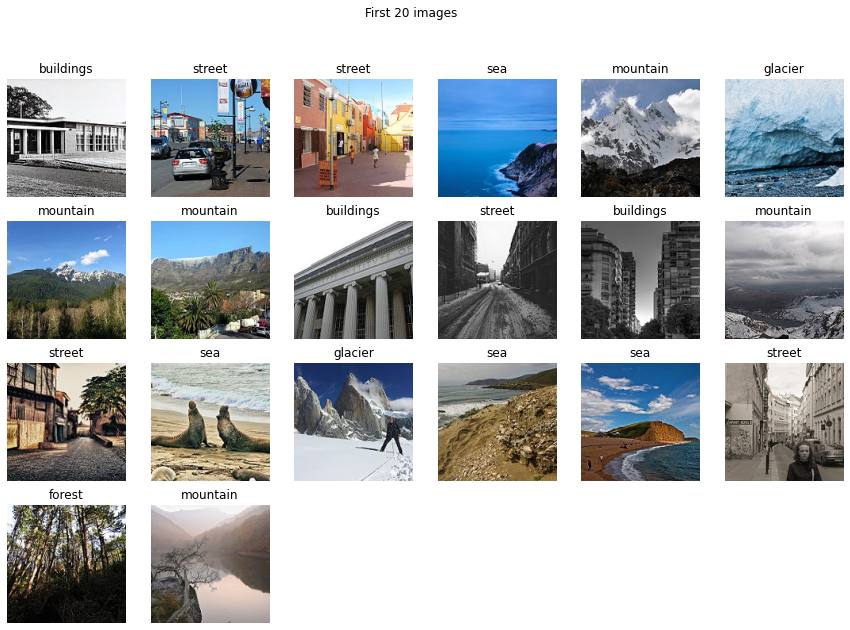

In [9]:
# let's see a few training examples!
display_images(X_train, [class_labels[np.argmax(y_train[i])] for i in range (0, len(y_train))],
    num_examples = 20, images_per_row = 6)

---
Modeling

- In all, the 3 of us (Gabe, Injung, and Gleb) tried over 12 different models amongst us, with strategies including:
  - Varying numbers of convolution filters, layers, FNN neurons, and training epochs
  - Regularization via L2, Dropout and EarlyStopping
  - Image augmentation using RandomFlip, RandomRotation and RandomZoom
  - Use of AveragePooling layers in place of MaxPooling
  - Pre-trained models for transfer learning
- Since these models are extensive and take a long time to run, we're including just our best models below - one from each of us, in ascending order of performance (accuracy while minimizing overfitting)!

In [10]:
# evaluation function
# Also from Gabe's lab 9.2!
def evaluate_models(models, histories, X_test, class_labels):
    '''
    Uses pre-compiled, pre-fit neural network classification models and their fit histories
    to generate useful statistics
    NOTE: assumes models were compiled with metrics including 'acc'

    Parameters:
    - models (list): list of pre-compiled, pre-fit models
    - histories (list): list of model histories - should be same length as models
    - X_test (array): test data of appropriate shape to make predictions on
    - class_labels (list): list of all possible class labels

    Displays:
    - Plots of confusion matrix, train/val loss over epochs, and test prediction counts

    Returns:
    - DataFrame containing model name, train/validation loss, train/validation accuracy
    '''

    assert type(models) == list
    assert type(histories) == list

    num_models = len(models)
    assert len(histories) == num_models

    model_stats = pd.DataFrame(columns = ['model_name', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

    fig = plt.figure(figsize = (20, num_models * 5.2))
    subfigs = fig.subfigures(num_models, wspace = 0.2, hspace = 0.2)
    if num_models == 1:
        subfigs = [subfigs]

    for i, model in enumerate(models):
        model_name = f'model {i}'

        train_loss = histories[i].history['loss']
        val_loss = histories[i].history['val_loss']
        train_acc = histories[i].history['acc']
        val_acc = histories[i].history['val_acc']

        # append our values to the stats dataframe
        model_stats.loc[len(model_stats)] = [model_name, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]]

        # display metrics
        # https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
        subfigs[i].suptitle(model_name)
        axs = subfigs[i].subplots(1, 3)

        # confusion matrix
        val_preds = np.array([np.argmax(x) for x in model.predict(X_val, verbose = 0)]).reshape(-1)
        true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
        axs[0].set_title('Confusion Matrix on Validation Set')
        ConfusionMatrixDisplay.from_predictions(true_preds, val_preds, display_labels = class_labels, ax = axs[0], xticks_rotation = 45)

        # performance of train vs val
        
        epoch_labels = histories[i].epoch
        axs[1].set_title(f'Loss by Epoch - Training vs. Validation')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel(model.loss)
        axs[1].set_xticks(epoch_labels, epoch_labels)
        axs[1].plot(train_loss, label = 'Training Loss', color = '#185fad')
        axs[1].plot(val_loss, label = 'Validation Loss', color = 'orange')
        axs[1].legend()
        
        # overview of test predictions
        test_class_probs = model.predict(X_test, batch_size = 128, verbose = 0)
        test_preds = [np.argmax(x) for x in test_class_probs]
        preds_df = pd.DataFrame([[class_labels[x], test_preds.count(x)]
            for x in set(test_preds)], columns = ['article', 'test_pred_count']).set_index('article')
        axs[2].set_title(f'Test Prediction Counts')
        preds_df.plot.barh(ax = axs[2])
        axs[2].get_legend().remove()

    return model_stats
        

In [11]:
# make a list of models and a list of histories so we can compare
models = []
histories = []

In [12]:
# model 0
# very simple CNN
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(6, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model)
histories.append(history)

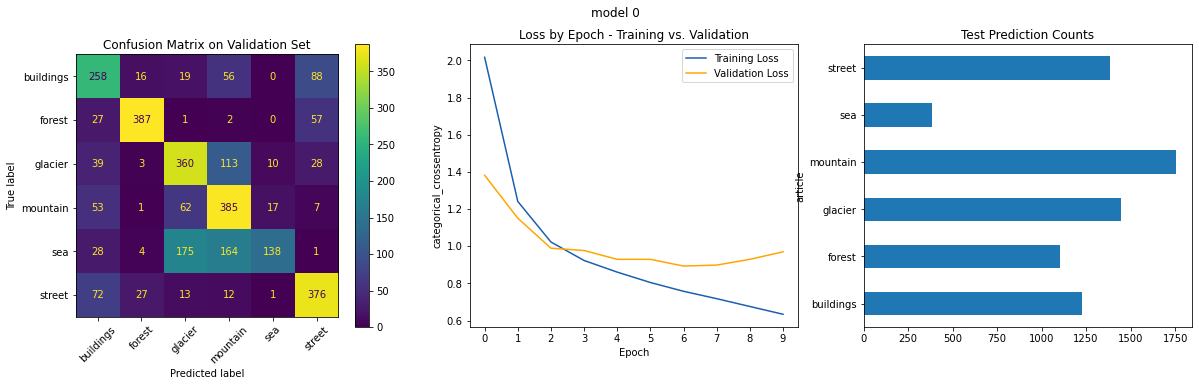

In [13]:
# let's see how we're doing so far!
stats = evaluate_models(models, histories, X_test, class_labels)

In [14]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.633942,0.969843,0.779607,0.634667


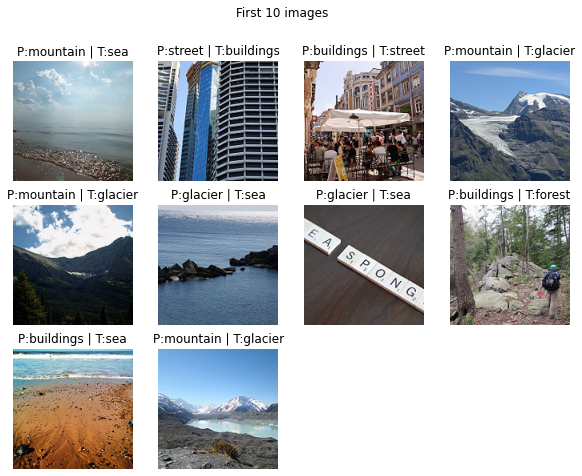

In [15]:
# just for fun, let's sample some of the confusion for the first model's validation set
# P indicates prediction, T indicates true value
val_preds = np.array([np.argmax(x) for x in models[0].predict(X_val, verbose = 0)]).reshape(-1)
true_preds = np.array([np.argmax(x) for x in y_val]).reshape(-1)
mismatches = [i for i in range(0, len(val_preds)) if val_preds[i] != true_preds[i]]
display_images([X_val[i] for i in mismatches], [f'P:{class_labels[val_preds[i]]} | T:{class_labels[true_preds[i]]}' for i in mismatches])

CONCLUSIONS
- Our validation accuracy, at 0.63, is not great, and we're clearly overfit
- The most prevalent misclassifications are:
  - buildings vs. street (understandably)
  - buildings vs. mountain
  - glacier vs. mountain (understandably)
- Time to see what we can do to improve both our bias and our variance

In [16]:
# model 1
# L2
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(6, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model)
histories.append(history)

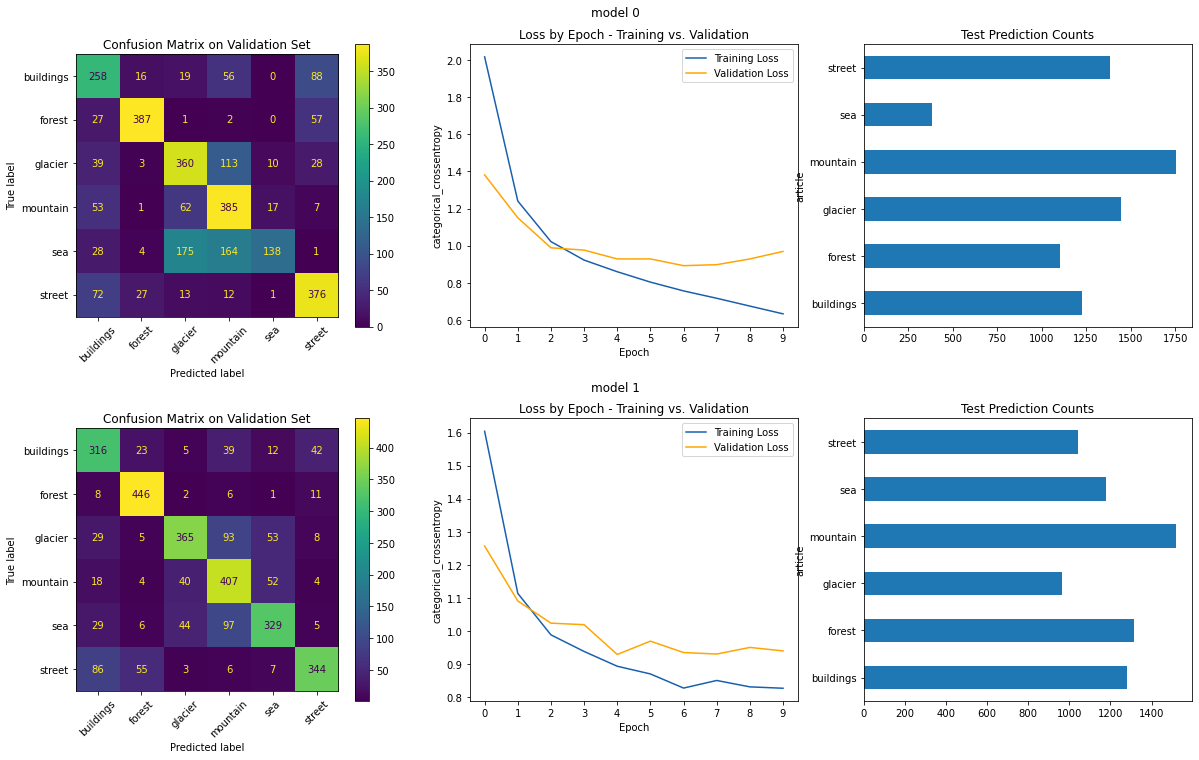

In [17]:
stats = evaluate_models(models, histories, X_test, class_labels)

In [18]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.633942,0.969843,0.779607,0.634667
1,model 1,0.826796,0.939907,0.774619,0.735667


CONCLUSIONS
- We've greatly improved our validation accuracy from 0.63 to 0.74
- We've closed the gap between training and validation significantly from 0.14 to 0.04
- Most of our misclassifications are still in the same areas - also noticing the following:
  - forest vs. street
  - sea vs. glacier
- We still have room for improvement!

In [19]:
# model 2
# added Average pooling
model_4 = Sequential()
model_4.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model_4.add(AveragePooling2D(pool_size = (2, 2)))
model_4.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (150, 150, 3), kernel_regularizer=l2(0.00005)))
model_4.add(AveragePooling2D(pool_size = (2, 2)))
model_4.add(Flatten())
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(6, activation = 'softmax'))

model_4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])
history = model_4.fit(X_train, y_train, batch_size = 128, epochs = 10, verbose = 0, validation_data = (X_val, y_val))

models.append(model_4)
histories.append(history)

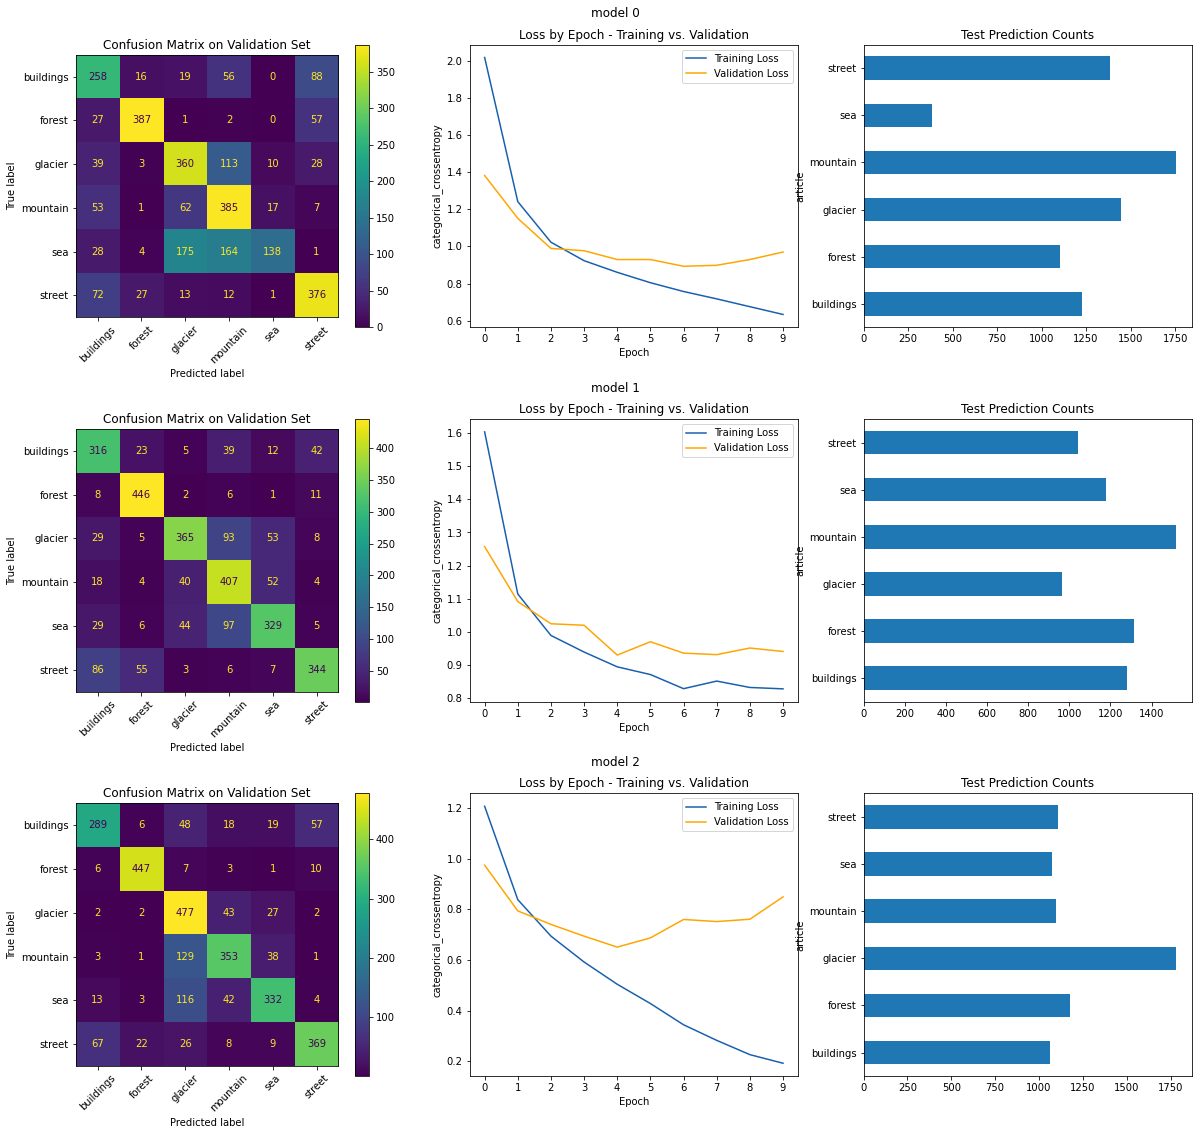

In [20]:
stats = evaluate_models(models, histories, X_test, class_labels)

In [21]:
stats

,model_name,train_loss,val_loss,train_acc,val_acc
0,model 0,0.633942,0.969843,0.779607,0.634667
1,model 1,0.826796,0.939907,0.774619,0.735667
2,model 2,0.191808,0.848591,0.937081,0.755667


CONCLUSIONS
- Our accuracy has improved by 0.02
- We're clearly seeing some overfitting creeping in - might be worth combining this model with some regularization techniques in the future
- No new misclassifications to note

In [ ]:
# model 3
# pre-trained model VGG19 for transfer learning
pretrained_model = VGG19(input_shape=[150,150,3], include_top=False)
pretrained_model.trainable = True

model_trans=Sequential()
model_trans.add(pretrained_model)
model_trans.add(Flatten())

model_trans.add(Dense(128,activation="relu"))
model_trans.add(Dense(64,activation="relu"))
model_trans.add(Dense(6,activation="softmax"))
model_trans.compile(loss = CategoricalCrossentropy(),optimizer='adam',metrics=['acc'])
history_cnn_trans=model_trans.fit(X_train,y_train,batch_size=128,validation_data=(X_val,y_val),epochs=10,verbose=1)

CONCLUSIONS
- **NOTE:** since model #3 takes a long time to run (>40 min on our GPU), we will not include the actual results here - please see [here](./vgg19.ipynb) for the results
- This is our best-performing model, with training accuracy of **0.87** and validation accuracy of **0.86**.
- Given the choice among our 12 models, we would choose this as our production model.